# Library Imports

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import io
# from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score,\
                            precision_score, recall_score, accuracy_score,\
                            average_precision_score, precision_recall_curve,\
                            matthews_corrcoef, roc_curve
from imblearn.over_sampling import RandomOverSampler
from src.helper_functions import load_data, get_model_perfs, init_model_perfs,\
                                 save_model, save_model_perfs, check_is_best,\
                                 read_model, evaluate_model_predictions,\
                                 update_model_perfs, check_and_save,\
                                 adjusted_classes, mcc
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.callbacks import Callback
from keras.layers import Dense, Activation, Dropout
keras.__version__

'2.2.5'

# Load Data

In [4]:
x_tr, y_tr, x_te, y_te = load_data()

# Build Neural Network

Following the desciption in section 2.2.4 of the [DeepTox article](https://www.frontiersin.org/articles/10.3389/fenvs.2015.00080/full), I tried to use intermediate values in [Table 2](https://www.frontiersin.org/articles/10.3389/fenvs.2015.00080/full#T2) to build the neural network:

Following [this question/answer](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model) and [this question/answer](https://stackoverflow.com/questions/54065733/how-to-employ-the-scikit-learn-evaluation-metrics-functions-with-keras-in-python) to implement usage of recall in model training:

In [4]:
drop_out=0.5    # DeepTox range: 0.5, 0.2, 0
L2_reg = 0.0001 # Default = 0.01
layers = 3      # DeepTox range: 1, 2, 3, 4
act = 'sigmoid' # Consider sigmoid and tanh
neurons = 1024  # DeepTox range: 1024, 2048, 4096, 8192, 16384
# Info on decay: https://datascience.stackexchange.com/questions/26112/decay-parameter-in-keras-optimizers
decay = 0       # DeepTox range: 10^-4, 10^-5, 10^-6
learn_rate = 0.1  #Research appropriate range
DNN = keras.Sequential()
DNN.add(Dense(neurons, activation=act,input_shape=x_tr.shape[1:],name='h0_'+act+'_activation'))
DNN.add(Dropout(rate=drop_out,name='Dropout0'))
for i in range(1,layers):
    DNN.add(Dense(units=neurons, activation=act,\
                  name='h'+str(i)+'_'+act+'_activation',\
                  kernel_regularizer=keras.regularizers.l2(L2_reg)))
    DNN.add(Dropout(rate=drop_out,name='Dropout'+str(i)))
DNN.add(Dense(units=1, activation='sigmoid'))
keras.optimizers.Adam(lr=learn_rate, beta_1=0.9,\
                      beta_2=0.999, decay=decay, amsgrad=False)
DNN.compile(optimizer='adam', loss='binary_crossentropy',\
            metrics=['accuracy'])
DNN.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h0_sigmoid_activation (Dense (None, 1024)              1684480   
_________________________________________________________________
Dropout0 (Dropout)           (None, 1024)              0         
_________________________________________________________________
h1_sigmoid_activation (Dense (None, 1024)              1049600   
_________________________________________________________________
Dropout1 (Dropout)           (None, 1024)              0         
_________________________________________________________________
h2_sigmoid_activation (Dense (None, 1024)              1049600   
_________________________________________________________________

# Train DNN's

In [5]:
for target in y_tr.columns:
    # Determine rows with available data
    rows_tr = np.isfinite(y_tr[target]).values
    rows_te = np.isfinite(y_te[target]).values
    x,y = x_tr[rows_tr], y_tr[target][rows_tr]
    
    # Address Class Imbalance
    x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, \
                                                      test_size=0.2, random_state=42)
    ros = RandomOverSampler(random_state=0)
    x_resampled, y_resampled = ros.fit_sample(x_train,y_train)
    
    # Train the DNN
    DNN.fit(
        x_resampled, y_resampled, batch_size=512, epochs=100,\
        validation_data=(x_val,y_val), verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=16,verbose=1,\
                                          restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)
        ])
    
    # Get predictions, calculate model performance and save info
    p_te = DNN.predict(x_te[rows_te])[:,0]
    y_testing=y_te[target][rows_te]
    auc_te = roc_auc_score(y_testing, p_te)
    print("%15s: %3.5f" % (target, auc_te))

    y_hat_testing=DNN.predict_classes(x_te[rows_te])
    average_precision=average_precision_score(y_testing,p_te)
    mv=evaluate_model_predictions(target,'DNN',0.5,y_testing,y_hat_testing,\
                                  auc_te,average_precision)
    filename = check_and_save(target,mv,DNN,True)
    
    # Find max F1 varying probability threshold, calculate modified performance, save
    precision, recall, thresholds = precision_recall_curve(y_testing,p_te)
    # f1 = 2*precision*recall/(precision+recall)  # Sometimes precision=recall=0!
    p,r,t = zip(*[i for i in zip(precision,recall,np.append(thresholds,1)) if i[0:2]!=(0,0)])
    p,r,t = np.array(p),np.array(r),np.array(t)
    f1 = 2*p*r/(p+r)
    m_idx = np.argmax(f1)
    m_thresh = thresholds[m_idx]
    y_hat_testing_adj=adjusted_classes(p_te,m_thresh)
    mv=evaluate_model_predictions(target,'DNN_modT',m_thresh,y_testing,y_hat_testing_adj,\
                                  auc_te,average_precision)
    if filename is None:
        check_and_save(target,mv,DNN,True)
    else:
        check_and_save(target,mv,filename,True)
    display(get_model_perfs(target))

Instructions for updating:
Use tf.cast instead.
Train on 11934 samples, validate on 1689 samples
Epoch 1/100
11934/11934 [==============================] - 3s 227us/step - loss: 1.1133 - acc: 0.5215 - val_loss: 0.7070 - val_acc: 0.8840
Epoch 2/100
11934/11934 [==============================] - 2s 175us/step - loss: 0.8746 - acc: 0.5747 - val_loss: 0.8319 - val_acc: 0.4938
Epoch 3/100
11934/11934 [==============================] - 2s 181us/step - loss: 0.7788 - acc: 0.6629 - val_loss: 0.7846 - val_acc: 0.5595
Epoch 4/100
11934/11934 [==============================] - 3s 210us/step - loss: 0.7400 - acc: 0.6865 - val_loss: 0.6602 - val_acc: 0.7105
Epoch 5/100
11934/11934 [==============================] - 3s 210us/step - loss: 0.7156 - acc: 0.6886 - val_loss: 0.5235 - val_acc: 0.8502
Epoch 6/100
11934/11934 [==============================] - 2s 200us/step - loss: 0.6984 - acc: 0.7056 - val_loss: 0.8266 - val_acc: 0.5317
Epoch 7/100
11934/11934 [==============================] - 2s 201us/s

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.911475,0.756757,0.383562,0.509091,0.905028,0.602102,"[[528, 9], [45, 28]]",RF0.joblib
1,RF_modT,0.235000,0.842623,0.424837,0.890411,0.575221,0.905028,0.602102,"[[449, 88], [8, 65]]",RF_modT0.joblib
2,DNN,0.500000,0.814754,0.364865,0.739726,0.488688,0.864723,0.524576,"[[443, 94], [19, 54]]",DNN0.h5
3,DNN_modT,0.773516,0.901639,0.603175,0.520548,0.558824,0.864723,0.524576,"[[512, 25], [35, 38]]",DNN_modT0.h5


Train on 14834 samples, validate on 1931 samples
Epoch 1/100
14834/14834 [==============================] - 3s 221us/step - loss: 1.0468 - acc: 0.4847 - val_loss: 0.9818 - val_acc: 0.4443
Epoch 2/100
14834/14834 [==============================] - 3s 221us/step - loss: 0.9139 - acc: 0.5450 - val_loss: 0.9631 - val_acc: 0.4459
Epoch 3/100
14834/14834 [==============================] - 3s 215us/step - loss: 0.8575 - acc: 0.5810 - val_loss: 0.8899 - val_acc: 0.4858
Epoch 4/100
14834/14834 [==============================] - 3s 217us/step - loss: 0.8338 - acc: 0.5866 - val_loss: 0.8453 - val_acc: 0.5049
Epoch 5/100
14834/14834 [==============================] - 3s 217us/step - loss: 0.8115 - acc: 0.6066 - val_loss: 0.8269 - val_acc: 0.5308
Epoch 6/100
14834/14834 [==============================] - 3s 209us/step - loss: 0.7909 - acc: 0.6201 - val_loss: 0.8087 - val_acc: 0.5526
Epoch 7/100
14834/14834 [==============================] - 3s 212us/step - loss: 0.7809 - acc: 0.6283 - val_loss: 0.7

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.981229,0.666667,0.166667,0.266667,0.678934,0.232723,"[[573, 1], [10, 2]]",RF0.joblib
1,RF_modT,0.730000,0.982935,1.000000,0.166667,0.285714,0.678934,0.232723,"[[574, 0], [10, 2]]",RF_modT0.joblib
2,DNN,0.500000,0.721843,0.042424,0.583333,0.079096,0.741507,0.168663,"[[416, 158], [5, 7]]",DNN0.h5
3,DNN_modT,0.792447,0.965870,0.250000,0.333333,0.285714,0.741507,0.168663,"[[562, 12], [8, 4]]",DNN_modT0.h5


Train on 13670 samples, validate on 1771 samples
Epoch 1/100
13670/13670 [==============================] - 3s 207us/step - loss: 0.6926 - acc: 0.7134 - val_loss: 0.5940 - val_acc: 0.7493
Epoch 2/100
13670/13670 [==============================] - 3s 214us/step - loss: 0.6916 - acc: 0.7143 - val_loss: 0.5947 - val_acc: 0.7493
Epoch 3/100
13670/13670 [==============================] - 3s 212us/step - loss: 0.6977 - acc: 0.7115 - val_loss: 0.5955 - val_acc: 0.7487
Epoch 4/100
13670/13670 [==============================] - 3s 211us/step - loss: 0.6946 - acc: 0.7108 - val_loss: 0.5961 - val_acc: 0.7487

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 5/100
13670/13670 [==============================] - 3s 210us/step - loss: 0.6950 - acc: 0.7102 - val_loss: 0.5964 - val_acc: 0.7487
Epoch 6/100
13670/13670 [==============================] - 3s 212us/step - loss: 0.6970 - acc: 0.7123 - val_loss: 0.5967 - val_acc: 0.7487
Epoch 7/100
13670/13670 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.982818,0.000000,0.000,0.000000,0.763284,0.060344,"[[572, 2], [8, 0]]",RF0.joblib
1,RF_modT,0.270000,0.979381,0.166667,0.125,0.142857,0.763284,0.060344,"[[569, 5], [7, 1]]",RF_modT0.joblib
2,DNN,0.500000,0.738832,0.020000,0.375,0.037975,0.635126,0.030153,"[[427, 147], [5, 3]]",DNN0.h5
3,DNN_modT,0.762549,0.929553,0.054054,0.250,0.088889,0.635126,0.030153,"[[539, 35], [6, 2]]",DNN_modT0.h5


Train on 11300 samples, validate on 1488 samples
Epoch 1/100
11300/11300 [==============================] - 2s 201us/step - loss: 0.7350 - acc: 0.6379 - val_loss: 0.5618 - val_acc: 0.7708
Epoch 2/100
11300/11300 [==============================] - 2s 209us/step - loss: 0.7377 - acc: 0.6377 - val_loss: 0.5619 - val_acc: 0.7708
Epoch 3/100
11300/11300 [==============================] - 2s 214us/step - loss: 0.7319 - acc: 0.6388 - val_loss: 0.5619 - val_acc: 0.7708
Epoch 4/100
11300/11300 [==============================] - 2s 210us/step - loss: 0.7355 - acc: 0.6370 - val_loss: 0.5620 - val_acc: 0.7708

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
Epoch 5/100
11300/11300 [==============================] - 2s 213us/step - loss: 0.7381 - acc: 0.6356 - val_loss: 0.5620 - val_acc: 0.7708
Epoch 6/100
11300/11300 [==============================] - 2s 214us/step - loss: 0.7360 - acc: 0.6382 - val_loss: 0.5620 - val_acc: 0.7708
Epoch 7/100
11300/11300 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.928030,1.000000,0.025641,0.050000,0.771931,0.311884,"[[489, 0], [38, 1]]",RF0.joblib
1,RF_modT,0.130000,0.840909,0.235294,0.512821,0.322581,0.771931,0.311884,"[[424, 65], [19, 20]]",RF_modT0.joblib
2,DNN,0.500000,0.772727,0.159664,0.487179,0.240506,0.718158,0.143086,"[[389, 100], [20, 19]]",DNN0.h5
3,DNN_modT,0.475931,0.767045,0.166667,0.538462,0.254545,0.718158,0.143086,"[[384, 105], [18, 21]]",DNN_modT0.h5


Train on 11196 samples, validate on 1593 samples
Epoch 1/100
11196/11196 [==============================] - 2s 200us/step - loss: 0.7824 - acc: 0.6451 - val_loss: 0.5880 - val_acc: 0.7589
Epoch 2/100
11196/11196 [==============================] - 2s 217us/step - loss: 0.7853 - acc: 0.6436 - val_loss: 0.5880 - val_acc: 0.7589
Epoch 3/100
11196/11196 [==============================] - 2s 214us/step - loss: 0.7875 - acc: 0.6437 - val_loss: 0.5880 - val_acc: 0.7589
Epoch 4/100
11196/11196 [==============================] - 2s 209us/step - loss: 0.7822 - acc: 0.6476 - val_loss: 0.5880 - val_acc: 0.7589

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
Epoch 5/100
11196/11196 [==============================] - 2s 208us/step - loss: 0.7862 - acc: 0.6417 - val_loss: 0.5880 - val_acc: 0.7589
Epoch 6/100
11196/11196 [==============================] - 2s 212us/step - loss: 0.7820 - acc: 0.6442 - val_loss: 0.5880 - val_acc: 0.7589
Epoch 7/100
11196/11196 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.916667,0.785714,0.215686,0.338462,0.769007,0.445565,"[[462, 3], [40, 11]]",RF0.joblib
1,RF_modT,0.400000,0.912791,0.607143,0.333333,0.430380,0.769007,0.445565,"[[454, 11], [34, 17]]",RF_modT0.joblib
2,DNN,0.500000,0.748062,0.203008,0.529412,0.293478,0.736369,0.280064,"[[359, 106], [24, 27]]",DNN0.h5
3,DNN_modT,0.625295,0.815891,0.270833,0.509804,0.353741,0.736369,0.280064,"[[395, 70], [25, 26]]",DNN_modT0.h5


Train on 13734 samples, validate on 1808 samples
Epoch 1/100
13734/13734 [==============================] - 3s 200us/step - loss: 0.7634 - acc: 0.6589 - val_loss: 0.6040 - val_acc: 0.7406
Epoch 2/100
13734/13734 [==============================] - 3s 211us/step - loss: 0.7638 - acc: 0.6589 - val_loss: 0.6040 - val_acc: 0.7406
Epoch 3/100
13734/13734 [==============================] - 3s 211us/step - loss: 0.7642 - acc: 0.6591 - val_loss: 0.6040 - val_acc: 0.7406
Epoch 4/100
13734/13734 [==============================] - 3s 208us/step - loss: 0.7649 - acc: 0.6557 - val_loss: 0.6040 - val_acc: 0.7406

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.313226188509272e-13.
Epoch 5/100
13734/13734 [==============================] - 3s 212us/step - loss: 0.7620 - acc: 0.6594 - val_loss: 0.6040 - val_acc: 0.7406
Epoch 6/100
13734/13734 [==============================] - 3s 210us/step - loss: 0.7610 - acc: 0.6589 - val_loss: 0.6040 - val_acc: 0.7406
Epoch 7/100
13734/13734 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.50000,0.971667,1.000000,0.15,0.260870,0.750345,0.268778,"[[580, 0], [17, 3]]",RF0.joblib
1,RF_modT,0.30500,0.965000,0.461538,0.30,0.363636,0.750345,0.268778,"[[573, 7], [14, 6]]",RF_modT0.joblib
2,DNN,0.50000,0.725000,0.049689,0.40,0.088398,0.678319,0.069591,"[[427, 153], [12, 8]]",DNN0.h5
3,DNN_modT,0.74828,0.915000,0.102564,0.20,0.135593,0.678319,0.069591,"[[545, 35], [16, 4]]",DNN_modT0.h5


Train on 13140 samples, validate on 1691 samples
Epoch 1/100
13140/13140 [==============================] - 3s 201us/step - loss: 0.8473 - acc: 0.6414 - val_loss: 0.5922 - val_acc: 0.7463
Epoch 2/100
13140/13140 [==============================] - 3s 213us/step - loss: 0.8494 - acc: 0.6419 - val_loss: 0.5922 - val_acc: 0.7463
Epoch 3/100
13140/13140 [==============================] - 3s 213us/step - loss: 0.8480 - acc: 0.6416 - val_loss: 0.5922 - val_acc: 0.7463
Epoch 4/100
13140/13140 [==============================] - 3s 211us/step - loss: 0.8501 - acc: 0.6409 - val_loss: 0.5922 - val_acc: 0.7463

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.9103831839091474e-14.
Epoch 5/100
13140/13140 [==============================] - 3s 210us/step - loss: 0.8500 - acc: 0.6400 - val_loss: 0.5922 - val_acc: 0.7463
Epoch 6/100
13140/13140 [==============================] - 3s 211us/step - loss: 0.8496 - acc: 0.6407 - val_loss: 0.5922 - val_acc: 0.7463
Epoch 7/100
13140/13140 [==========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.947107,0.000000,0.000000,0.000000,0.709846,0.129989,"[[573, 1], [31, 0]]",RF0.joblib
1,RF_modT,0.130000,0.890909,0.181818,0.322581,0.232558,0.709846,0.129989,"[[529, 45], [21, 10]]",RF_modT0.joblib
2,DNN,0.500000,0.750413,0.115385,0.580645,0.192513,0.740390,0.109550,"[[436, 138], [13, 18]]",DNN0.h5
3,DNN_modT,0.577705,0.798347,0.130081,0.516129,0.207792,0.740390,0.109550,"[[467, 107], [15, 16]]",DNN_modT0.h5


Train on 10006 samples, validate on 1481 samples
Epoch 1/100
10006/10006 [==============================] - 2s 198us/step - loss: 0.8277 - acc: 0.6072 - val_loss: 0.6143 - val_acc: 0.7387
Epoch 2/100
10006/10006 [==============================] - 2s 209us/step - loss: 0.8290 - acc: 0.6072 - val_loss: 0.6143 - val_acc: 0.7387
Epoch 3/100
10006/10006 [==============================] - 2s 214us/step - loss: 0.8288 - acc: 0.6097 - val_loss: 0.6143 - val_acc: 0.7387
Epoch 4/100
10006/10006 [==============================] - 2s 217us/step - loss: 0.8261 - acc: 0.6060 - val_loss: 0.6143 - val_acc: 0.7387

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.094947449716085e-16.
Epoch 5/100
10006/10006 [==============================] - 2s 211us/step - loss: 0.8253 - acc: 0.6076 - val_loss: 0.6143 - val_acc: 0.7387
Epoch 6/100
10006/10006 [==============================] - 2s 213us/step - loss: 0.8243 - acc: 0.6088 - val_loss: 0.6143 - val_acc: 0.7387
Epoch 7/100
10006/10006 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.841441,0.592593,0.172043,0.266667,0.780838,0.430711,"[[451, 11], [77, 16]]",RF0.joblib
1,RF_modT,0.340000,0.823423,0.476190,0.537634,0.505051,0.780838,0.430711,"[[407, 55], [43, 50]]",RF_modT0.joblib
2,DNN,0.500000,0.762162,0.355556,0.516129,0.421053,0.705500,0.347718,"[[375, 87], [45, 48]]",DNN0.h5
3,DNN_modT,0.457539,0.753153,0.353333,0.569892,0.436214,0.705500,0.347718,"[[365, 97], [40, 53]]",DNN_modT0.h5


Train on 14400 samples, validate on 1873 samples
Epoch 1/100
14400/14400 [==============================] - 3s 207us/step - loss: 0.7856 - acc: 0.6460 - val_loss: 0.6163 - val_acc: 0.7277
Epoch 2/100
14400/14400 [==============================] - 3s 216us/step - loss: 0.7849 - acc: 0.6498 - val_loss: 0.6163 - val_acc: 0.7277
Epoch 3/100
14400/14400 [==============================] - 3s 213us/step - loss: 0.7839 - acc: 0.6488 - val_loss: 0.6163 - val_acc: 0.7277
Epoch 4/100
14400/14400 [==============================] - 3s 215us/step - loss: 0.7871 - acc: 0.6468 - val_loss: 0.6163 - val_acc: 0.7277

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.842171078036277e-17.
Epoch 5/100
14400/14400 [==============================] - 3s 210us/step - loss: 0.7841 - acc: 0.6508 - val_loss: 0.6163 - val_acc: 0.7277
Epoch 6/100
14400/14400 [==============================] - 3s 213us/step - loss: 0.7849 - acc: 0.6462 - val_loss: 0.6163 - val_acc: 0.7277
Epoch 7/100
14400/14400 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.938907,0.000000,0.000000,0.000000,0.795625,0.427828,"[[584, 0], [38, 0]]",RF0.joblib
1,RF_modT,0.255000,0.948553,0.636364,0.368421,0.466667,0.795625,0.427828,"[[576, 8], [24, 14]]",RF_modT0.joblib
2,DNN,0.500000,0.736334,0.125000,0.552632,0.203883,0.711608,0.153415,"[[437, 147], [17, 21]]",DNN0.h5
3,DNN_modT,0.577705,0.789389,0.155556,0.552632,0.242775,0.711608,0.153415,"[[470, 114], [17, 21]]",DNN_modT0.h5


Train on 12766 samples, validate on 1684 samples
Epoch 1/100
12766/12766 [==============================] - 3s 201us/step - loss: 0.8939 - acc: 0.5726 - val_loss: 0.6040 - val_acc: 0.7387
Epoch 2/100
12766/12766 [==============================] - 3s 216us/step - loss: 0.8961 - acc: 0.5725 - val_loss: 0.6040 - val_acc: 0.7387
Epoch 3/100
12766/12766 [==============================] - 3s 213us/step - loss: 0.8974 - acc: 0.5715 - val_loss: 0.6040 - val_acc: 0.7387
Epoch 4/100
12766/12766 [==============================] - 3s 213us/step - loss: 0.8990 - acc: 0.5734 - val_loss: 0.6040 - val_acc: 0.7387

Epoch 00004: ReduceLROnPlateau reducing learning rate to 8.881784618863365e-19.
Epoch 5/100
12766/12766 [==============================] - 3s 210us/step - loss: 0.8931 - acc: 0.5728 - val_loss: 0.6040 - val_acc: 0.7387
Epoch 6/100
12766/12766 [==============================] - 3s 209us/step - loss: 0.8964 - acc: 0.5714 - val_loss: 0.6040 - val_acc: 0.7387
Epoch 7/100
12766/12766 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.965574,0.600000,0.136364,0.222222,0.759586,0.239563,"[[586, 2], [19, 3]]",RF0.joblib
1,RF_modT,0.340000,0.965574,0.545455,0.272727,0.363636,0.759586,0.239563,"[[583, 5], [16, 6]]",RF_modT0.joblib
2,DNN,0.500000,0.726230,0.055215,0.409091,0.097297,0.626739,0.054621,"[[434, 154], [13, 9]]",DNN0.h5
3,DNN_modT,0.450345,0.708197,0.066667,0.545455,0.118812,0.626739,0.054621,"[[420, 168], [10, 12]]",DNN_modT0.h5


Train on 10204 samples, validate on 1512 samples
Epoch 1/100
10204/10204 [==============================] - 2s 201us/step - loss: 0.7619 - acc: 0.6424 - val_loss: 0.6140 - val_acc: 0.7421
Epoch 2/100
10204/10204 [==============================] - 2s 218us/step - loss: 0.7654 - acc: 0.6400 - val_loss: 0.6140 - val_acc: 0.7421
Epoch 3/100
10204/10204 [==============================] - 2s 215us/step - loss: 0.7604 - acc: 0.6392 - val_loss: 0.6140 - val_acc: 0.7421
Epoch 4/100
10204/10204 [==============================] - 2s 219us/step - loss: 0.7587 - acc: 0.6449 - val_loss: 0.6140 - val_acc: 0.7421

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.7755576933948015e-20.
Epoch 5/100
10204/10204 [==============================] - 2s 214us/step - loss: 0.7617 - acc: 0.6446 - val_loss: 0.6140 - val_acc: 0.7421
Epoch 6/100
10204/10204 [==============================] - 2s 213us/step - loss: 0.7611 - acc: 0.6400 - val_loss: 0.6140 - val_acc: 0.7421
Epoch 7/100
10204/10204 [==========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.906077,0.615385,0.40,0.484848,0.930331,0.560184,"[[468, 15], [36, 24]]",RF0.joblib
1,RF_modT,0.382500,0.913444,0.600000,0.65,0.624000,0.930331,0.560184,"[[457, 26], [21, 39]]",RF_modT0.joblib
2,DNN,0.500000,0.815838,0.330508,0.65,0.438202,0.803882,0.296565,"[[404, 79], [21, 39]]",DNN0.h5
3,DNN_modT,0.505391,0.817680,0.333333,0.65,0.440678,0.803882,0.296565,"[[405, 78], [21, 39]]",DNN_modT0.h5


Train on 13340 samples, validate on 1781 samples
Epoch 1/100
13340/13340 [==============================] - 3s 206us/step - loss: 0.7926 - acc: 0.6395 - val_loss: 0.6058 - val_acc: 0.7344
Epoch 2/100
13340/13340 [==============================] - 3s 218us/step - loss: 0.7896 - acc: 0.6397 - val_loss: 0.6058 - val_acc: 0.7344
Epoch 3/100
13340/13340 [==============================] - 3s 215us/step - loss: 0.7886 - acc: 0.6389 - val_loss: 0.6058 - val_acc: 0.7344
Epoch 4/100
13340/13340 [==============================] - 3s 214us/step - loss: 0.7935 - acc: 0.6389 - val_loss: 0.6058 - val_acc: 0.7344

Epoch 00004: ReduceLROnPlateau reducing learning rate to 8.673617791858755e-22.
Epoch 5/100
13340/13340 [==============================] - 3s 213us/step - loss: 0.7917 - acc: 0.6403 - val_loss: 0.6058 - val_acc: 0.7344
Epoch 6/100
13340/13340 [==============================] - 3s 212us/step - loss: 0.7906 - acc: 0.6421 - val_loss: 0.6058 - val_acc: 0.7344
Epoch 7/100
13340/13340 [===========

,model,threshold,accuracy,precision,recall,f1,auc_roc,avg_precision,confusion_matrix,model_filename
0,RF,0.500000,0.933442,0.500000,0.024390,0.046512,0.806702,0.221990,"[[574, 1], [40, 1]]",RF0.joblib
1,RF_modT,0.220000,0.886364,0.254237,0.365854,0.300000,0.806702,0.221990,"[[531, 44], [26, 15]]",RF_modT0.joblib
2,DNN,0.500000,0.753247,0.150943,0.585366,0.240000,0.768696,0.168234,"[[440, 135], [17, 24]]",DNN0.h5
3,DNN_modT,0.540362,0.780844,0.169014,0.585366,0.262295,0.768696,0.168234,"[[457, 118], [17, 24]]",DNN_modT0.h5


# Performance Metrics Saving Development

In [ ]:
p_te = DNN.predict(x_te[rows_te])[:,0]
y_testing=y_te[target][rows_te]
auc_te = roc_auc_score(y_testing, p_te)
print("%15s: %3.5f" % (target, auc_te))

y_hat_testing=DNN.predict_classes(x_te[rows_te])
average_precision=average_precision_score(y_testing,p_te)
mv=evaluate_model_predictions(target,'DNN',0.5,y_testing,y_hat_testing,\
                              auc_te,average_precision)
#     check_and_save(target,mv,DNN,True)
display(mv)
precision, recall, thresholds = precision_recall_curve(y_testing,p_te)
# f1 = 2*precision*recall/(precision+recall)
p,r,t = zip(*[i for i in zip(precision,recall,np.append(thresholds,1)) if i[0:2]!=(0,0)])
p,r,t = np.array(p),np.array(r),np.array(t)
f1 = 2*p*r/(p+r)
m_idx = np.argmax(f1)
m_thresh = thresholds[m_idx]
y_hat_testing_adj=adjusted_classes(p_te,m_thresh)
mv=evaluate_model_predictions(target,'DNN_modT',m_thresh,y_testing,y_hat_testing_adj,\
                              auc_te,average_precision)
#     check_and_save(target,mv,DNN,True)
# display(get_model_perfs(target))
display(mv)

# Troubleshooting Precision-Recall Error

In [ ]:
f1 = 2*precision*recall/(precision+recall)

In [ ]:
a, b = zip(*zip(precision,recall))
type(a)

In [ ]:
p,r,t = zip(*[i for i in zip(precision,recall,np.append(thresholds,1)) if i[0:2]!=(0,0)])
p,r,t = np.array(p),np.array(r),np.array(t)
f1 = 2*p*r/(p+r)

# Testing DNN Model Saving.

In [6]:
filename = save_model(target,'DNN_test',DNN,True)
filename

'DNN_test0.h5'

In [7]:
read_model(target,filename)

In [8]:
keras.__version__

'2.2.5'

# Read Saved DNN Model

In [29]:
target = 'NR.AhR'
DNN = read_model(target,'DNN_modT0.h5')

# target = 'SR.HSE'
# DNN = read_model(target,'DNN_MaxMCC4.h5')

# target = 'SR.MPP'
# DNN = read_model(target,'DNN5.h5')

In [30]:
DNN.summary()

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h0_sigmoid_activation (Dense (None, 64)                105280    
_________________________________________________________________
Dropout0 (Dropout)           (None, 64)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 65        
Total params: 105,345
Trainable params: 105,345
Non-trainable params: 0
_________________________________________________________________


# Performance of Read DNN Model

In [31]:
rows_tr = np.isfinite(y_tr[target]).values
rows_te = np.isfinite(y_te[target]).values
y_testing=y_te[target][rows_te]
p_te = DNN.predict(x_te[rows_te])[:,0]
auc_te = roc_auc_score(y_te[target][rows_te], p_te)
average_precision=average_precision_score(y_testing, p_te)
print("%15s: %3.5f" % (target, auc_te))

         NR.AhR: 0.85306


In [32]:
y_hat_testing=DNN.predict_classes(x_te[rows_te])
evaluate_model_predictions(target, 'DNN', 0.5, y_testing, y_hat_testing, auc_te, average_precision)

model                                  DNN
threshold                              0.5
accuracy                               0.8
precision                         0.347826
recall                            0.767123
f1                                0.478632
auc_roc                           0.853065
mcc                               0.420919
avg_precision                      0.49692
confusion_matrix    [[432, 105], [17, 56]]
dtype: object

## ROC Curve

In [33]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

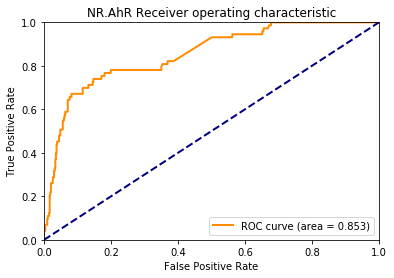

In [34]:
fpr, tpr, thresholds = roc_curve(y_te[target][rows_te], p_te)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc_te)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(target+' Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix at Alternate Decision Threshold

In [35]:
decision_threshold = 0.7035
y_testing=y_te[target][rows_te]
y_hat_testing_adj=adjusted_classes(p_te,decision_threshold)
print('Precision-Recall Curve "Average Precision": %0.4f' %average_precision)
mv=evaluate_model_predictions(target,'DNN',decision_threshold,y_testing,y_hat_testing_adj,\
                              auc_te,average_precision)
mv

Precision-Recall Curve "Average Precision": 0.4969


model                                 DNN
threshold                          0.7035
accuracy                         0.893443
precision                        0.547619
recall                           0.630137
f1                               0.585987
auc_roc                          0.853065
mcc                              0.526888
avg_precision                     0.49692
confusion_matrix    [[499, 38], [27, 46]]
dtype: object

## Precision-Recall Curve

In [36]:
precision, recall, thresholds = precision_recall_curve(y_testing,p_te)
precision, recall, thresholds = zip(*[i for i in zip(precision,recall,np.append(thresholds,1)) if i[0:2]!=(0,0)])
precision, recall, thresholds = np.array(precision),np.array(recall),np.array(thresholds)
f1 = 2*precision*recall/(precision+recall)
m_idx = np.argmax(f1)
m_thresh = thresholds[m_idx]
print('Max F1: %0.5f, threshold prob: %0.5f' % (f1[m_idx], m_thresh))
print('Max F1 Precision: %0.5f, Recall: %0.5f' % (precision[m_idx],recall[m_idx]))

Max F1: 0.59494, threshold prob: 0.70347
Max F1 Precision: 0.55294, Recall: 0.64384


In [37]:
thresholds[0]

0.17328140139579773

In [38]:
mccs = []
for th in thresholds:
    y_hat_testing_adj=adjusted_classes(p_te,th)
    mccs.append(matthews_corrcoef(y_testing,y_hat_testing_adj))

/Users/sean/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


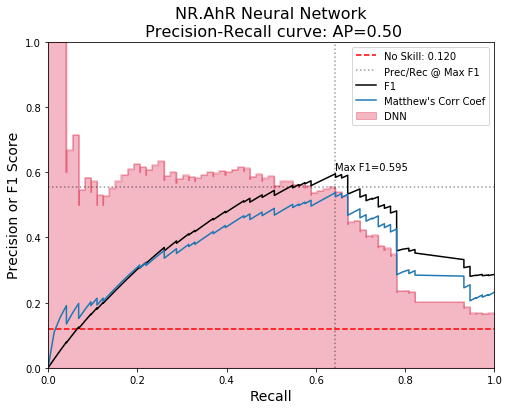

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
no_skill = len(y_testing[y_testing==1]) / len(y_testing)
fig = plt.figure(figsize=[8,8*4.8/6.4])
plt.step(recall, precision, color='crimson', alpha=0.3, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='crimson',\
                 label='DNN')
plt.plot([0, 1], [no_skill, no_skill], color='r', linestyle='--', label='No Skill:'+' %0.3f' % no_skill)
plt.plot([0, 1], [precision[m_idx],precision[m_idx]], color='k', alpha=0.4, linestyle=':')
plt.plot([recall[m_idx],recall[m_idx]],[0, 1], color='k', alpha=0.4,linestyle=':',\
         label='Prec/Rec @ Max F1')
plt.text(recall[m_idx], f1[m_idx]+0.01, 'Max F1={0:0.3f}'.format(f1[m_idx]))
plt.plot(recall,f1,color='k',label='F1')
plt.plot(recall,mccs,label="Matthew's Corr Coef")
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision or F1 Score', fontsize=14)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.legend()
title=target+' Neural Network\n Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision)
plt.title(title, fontsize=16);
fig.savefig('./reports/figures/'+target+'_DNN_PrecisionRecallCurve2.svg',\
            format='svg', dpi=1200, transparent=True, bbox_inches = "tight");

In [51]:
for i in zip(precision,recall,f1,mccs,np.append(thresholds,1)):
    print(i)

(0.16704805491990846, 1.0, 0.28627450980392155, 0.23198324564311515, 0.17328140139579773)
(0.1651376146788991, 0.9863013698630136, 0.2829076620825148, 0.22173369633779677, 0.17465224862098694)
(0.16551724137931034, 0.9863013698630136, 0.28346456692913385, 0.2226895755682889, 0.1813332438468933)
(0.16589861751152074, 0.9863013698630136, 0.28402366863905326, 0.22364576427189672, 0.1842179298400879)
(0.16628175519630484, 0.9863013698630136, 0.2845849802371542, 0.2246022885079155, 0.18537762761116028)
(0.16511627906976745, 0.9726027397260274, 0.2823061630218688, 0.216399972952515, 0.18541648983955383)
(0.1655011655011655, 0.9726027397260274, 0.28286852589641437, 0.2173758670266673, 0.18947604298591614)
(0.1658878504672897, 0.9726027397260274, 0.2834331337325349, 0.2183519976700012, 0.1915532648563385)
(0.16627634660421545, 0.9726027397260274, 0.284, 0.21932839276507035, 0.19245806336402893)
(0.16666666666666666, 0.9726027397260274, 0.2845691382765531, 0.22030508001372517, 0.194896459579467

## Compare Predictions with Actually Toxic Compounds

In [52]:
print('Max F1 Decision Threshold: %0.4f' % m_thresh)
y_hat_testing_adj=adjusted_classes(p_te,m_thresh)
y_hat=pd.DataFrame(y_hat_testing_adj,columns=['DNN'],index=y_te[rows_te].index)
compare_TP = pd.concat([y_te[target][rows_te].astype('int'), y_hat],axis=1)
compare_TP[compare_TP[target]==1]

Max F1 Decision Threshold: 0.7035


,NR.AhR,DNN
NCGC00261776-01,1,1
NCGC00261662-01,1,0
NCGC00261119-01,1,0
NCGC00260831-01,1,1
NCGC00261395-01,1,0
...,...,...
NCGC00357175-01,1,1
NCGC00356994-01,1,1
NCGC00357111-01,1,0
NCGC00357249-01,1,1
